In [0]:
#fast ai

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
#import torch
#from torch import nn, optim
import seaborn as sns
from pathlib import Path
import PIL
import json
from fastai import *
from fastai.tabular import * 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "drive/My Drive/Colab Notebooks/Tabular/Janata/inputs"

final_submission.csv		      sample_submission_12th_April_9.csv
models				      sample_submission.csv
sample_submission_11th_April_1.2.csv  test.csv
sample_submission_11th_April_1.3.csv  train.csv


In [0]:
# Read data
train = pd.read_csv('drive/My Drive/Colab Notebooks/Tabular/Janata/inputs/train.csv')
test = pd.read_csv('drive/My Drive/Colab Notebooks/Tabular/Janata/inputs/test.csv')
sample_sub  = pd.read_csv('drive/My Drive/Colab Notebooks/Tabular/Janata/inputs/sample_submission.csv') 

In [0]:
#feature engineering and data prep

In [0]:
def extract_product(str):
    if ";"  in str:
        prd_lst = str.split(";")
        count_item = len(prd_lst)
        first_lv1 = prd_lst[0].split("/")[0]
        first_lv2 = prd_lst[0].split("/")[1]
        first_lv3 = prd_lst[0].split("/")[2]
        first_lv4 = prd_lst[0].split("/")[3]
        
        lv1_lst =[]
        lv2_lst =[]
        lv3_lst =[]
        lv4_lst =[]

        for item in prd_lst:
            lv1_lst.append(item.split("/")[0])
            lv2_lst.append(item.split("/")[1])
            lv3_lst.append(item.split("/")[2])
            lv4_lst.append(item.split("/")[3])
            
        unique_lv1 = len(set(lv1_lst))
        unique_lv2 = len(set(lv2_lst))
        unique_lv3 = len(set(lv2_lst))
        unique_lv4 = len(set(lv2_lst))
        most_freq_lv1 =  max(lv1_lst, key=Counter(lv1_lst).get)  
        most_freq_lv4 =  max(lv4_lst, key=Counter(lv4_lst).get)        
    else:
        lv_lst = str.split("/")
        first_lv1 = lv_lst[0]
        first_lv2 = lv_lst[1]
        first_lv3 = lv_lst[2]
        first_lv4 = lv_lst[3]
        
        count_item = 1
        unique_lv1 = 1
        unique_lv2 = 1
        unique_lv3 = 1
        unique_lv4 = 1
        
        most_freq_lv1 = first_lv1
        most_freq_lv4 = first_lv4
    return (count_item,first_lv1,first_lv2,first_lv3,first_lv4,unique_lv1,unique_lv2,unique_lv3,unique_lv4,most_freq_lv1)    

In [0]:
#Feature Extraction :
new_col = ('NumProduct','FirstA','FirstB','FirstC','FirstD','UniqueA','UniqueB','UniqueC','UniqueD','MostA')      
#new_col_lst = fullproductlist.apply(lambda x: extract_product(x))    

new_col_lst = train['ProductList'].apply(lambda x: extract_product(x))    
new_col_df = pd.DataFrame(new_col_lst.tolist(),columns =new_col)
train = pd.concat([train, new_col_df], axis=1)

new_col_lst = None
new_col_df = None

new_col_lst = test['ProductList'].apply(lambda x: extract_product(x))    
new_col_df = pd.DataFrame(new_col_lst.tolist(),columns =new_col)
test = pd.concat([test, new_col_df], axis=1)

In [0]:
# Time feature extraction
train['startTime'] = pd.to_datetime(train['startTime'])
train['endTime'] = pd.to_datetime(train['endTime'])
train['duration'] = train['endTime'] - train['startTime']
train['duration'] = train['duration'].astype('timedelta64[m]')
train['weekday'] = train['startTime'].dt.dayofweek
train['hour_24h'] = train['startTime'].dt.hour

In [0]:
test['startTime'] = pd.to_datetime(test['startTime'])
test['endTime'] = pd.to_datetime(test['endTime'])
test['duration'] = test['endTime'] - test['startTime']
test['duration'] = test['duration'].astype('timedelta64[m]')
test['weekday'] = test['startTime'].dt.dayofweek
test['hour_24h'] = test['startTime'].dt.hour

In [0]:
## Regularized Expanding mean scheme
# for features in ['MostA']:
#     cumsum = train.groupby([features,'gender']).cumcount()
#     #cumcnt = train.groupby(features).cumcount()  
    
#     train[features + 'meantarget'] = cumsum #/cumcnt
#     test[features + 'meantarget'] = cumsum #/cumcnt

In [0]:
drop_lst = ['session_id', 'startTime', 'endTime', 'ProductList']

In [0]:
#train['gender'] = train['gender'].map({'female':1,'male':0})

In [0]:
len(train.columns),len(test.columns)

(18, 17)

In [0]:
#train[['MostAmeantarget']]

In [0]:
train = train.drop(drop_lst,axis =1 )
test = test.drop(drop_lst,axis =1 )

In [0]:
train.columns

Index(['gender', 'NumProduct', 'FirstA', 'FirstB', 'FirstC', 'FirstD',
       'UniqueA', 'UniqueB', 'UniqueC', 'UniqueD', 'MostA', 'duration',
       'weekday', 'hour_24h'],
      dtype='object')

In [0]:
train.head()

,gender,NumProduct,FirstA,FirstB,FirstC,FirstD,UniqueA,UniqueB,UniqueC,UniqueD,MostA,duration,weekday,hour_24h
0,female,4,A00002,B00003,C00006,D28435,1,1,1,1,A00002,1.0,0,18
1,male,7,A00001,B00009,C00031,D29404,1,1,1,1,A00001,6.0,1,14
2,female,1,A00002,B00001,C00020,D16944,1,1,1,1,A00002,0.0,6,15
3,female,3,A00002,B00004,C00018,D10284,1,1,1,1,A00002,3.0,6,2
4,male,2,A00001,B00001,C00012,D30805,1,1,1,1,A00001,2.0,2,16


In [0]:
#train[['gender','MostA']].groupby(['gender','MostA']).MostA.count()


In [0]:
procs = [FillMissing, Categorify, Normalize]

In [0]:
cat_vars = ['FirstA', 'FirstB', 'FirstC', 'FirstD', 'MostA','weekday','hour_24h']
cont_vars = ['NumProduct',  'UniqueA', 'UniqueB', 'UniqueC', 'UniqueD','duration']

In [0]:
train[cat_vars] = train[cat_vars].astype('category')
test[cat_vars] = test[cat_vars].astype('category')

In [0]:
dep_var = 'gender'

In [0]:
train_df_len = len(train)
valid_idx = range(round(0.99*train_df_len), train_df_len)

In [0]:
path ='drive/My Drive/Colab Notebooks/Tabular/Janata/inputs/'

In [0]:
data = (TabularList.from_df(train, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_rand_pct(valid_pct=0.15)                
                .label_from_df(cols=dep_var)
                .add_test(TabularList.from_df(test, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

#TabularDataBunch.from_df(path, train, dep_var=dep_var, valid_idx=valid_idx, test_df=test)

In [0]:
data.show_batch(rows= 6)

FirstA,FirstB,FirstC,FirstD,MostA,weekday,hour_24h,NumProduct,UniqueA,UniqueB,UniqueC,UniqueD,duration,target
A00002,B00007,C00024,D06100,A00002,0,20,-0.5189,-0.1953,-0.3392,-0.3392,-0.3392,0.0011,female
A00002,B00017,C00139,D01775,A00002,4,21,-0.5189,-0.1953,-0.3392,-0.3392,-0.3392,0.0011,female
A00001,B00001,C00182,D13302,A00001,2,19,-0.0882,-0.1953,1.9198,1.9198,1.9198,0.0028,male
A00002,B00001,C00049,D15545,A00002,2,7,-0.5189,-0.1953,-0.3392,-0.3392,-0.3392,0.0011,female
A00002,B00002,C00002,D18768,A00002,0,21,-0.5189,-0.1953,-0.3392,-0.3392,-0.3392,0.0011,female
A00003,B00020,C00052,D22578,A00003,2,9,0.3424,-0.1953,-0.3392,-0.3392,-0.3392,0.0012,female


In [0]:
#learn = tabular_learner(data, layers=[ 200 , 100], ps=[0.001,0.01], emb_drop=0.04, emb_szs={'ID_code': 20}, metrics=accuracy , path='.')

In [0]:
#ps=[0.01,0.1],,  emb_drop=0.04, emb_szs={'MostA': 9},
learn = tabular_learner(data, layers=[250,150],metrics=accuracy,emb_szs={'MostA': 4,'MostD': 4})

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


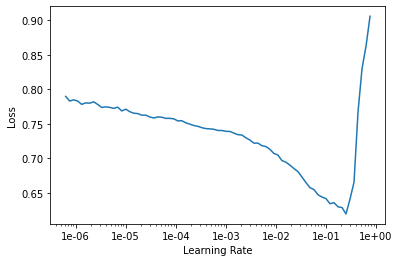

In [0]:
learn.recorder.plot()

In [0]:
lr = 5e-2
learn.unfreeze()
learn.fit_one_cycle(10, lr , wd = 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.418608,0.366995,0.877460,00:02
1,0.220795,0.437652,0.836825,00:02
2,0.193940,0.437987,0.871746,00:02
3,0.157419,0.554683,0.875556,00:02
4,0.107972,0.470606,0.876825,00:02
5,0.088442,0.600680,0.877460,00:02
6,0.068970,0.542949,0.880635,00:02
7,0.057693,0.627562,0.885079,00:02
8,0.041774,0.743887,0.885079,00:02
9,0.039313,0.751677,0.886984,00:02


In [0]:
lr = 0.001
lr = 1e-2
learn.unfreeze()
learn.fit_one_cycle(10, lr , wd = 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.041892,0.745473,0.885714,00:02
1,0.039211,0.663139,0.883175,00:02
2,0.044529,0.656512,0.887619,00:02
3,0.045121,0.716150,0.880635,00:02
4,0.047296,0.721589,0.870476,00:02
5,0.038252,0.731861,0.882540,00:02
6,0.037753,0.761155,0.876190,00:02
7,0.033907,0.790436,0.877460,00:02
8,0.030880,0.829403,0.878095,00:02
9,0.030251,0.830077,0.877460,00:02


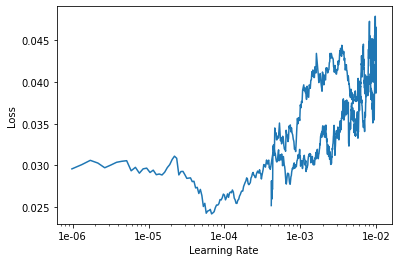

In [0]:
learn.recorder.plot()

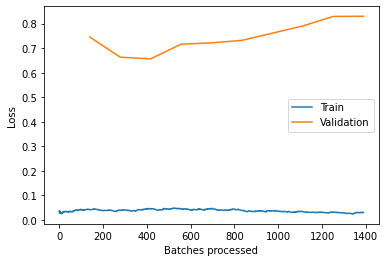

In [0]:
learn.recorder.plot_losses()

In [0]:
test_preds = learn.get_preds(ds_type=DatasetType.Test)
test_preds

[tensor([[9.9984e-01, 1.5504e-04],
         [9.9974e-01, 2.6483e-04],
         [9.9995e-01, 5.3363e-05],
         ...,
         [9.9131e-01, 8.6872e-03],
         [2.9293e-03, 9.9707e-01],
         [9.9959e-01, 4.0764e-04]]), tensor([0, 0, 0,  ..., 0, 0, 0])]

In [0]:
target_preds = test_preds[0][:,0]
target_preds
target_preds = np.where(target_preds > 0.5, 1, 0)
target_preds

array([1, 1, 1, 1, ..., 1, 1, 0, 1])

In [0]:
results = pd.DataFrame(data=target_preds, columns=["gender"])
results['gender'] = results['gender'].map({1:'female',0:'male'})
sample_sub['gender'] = results['gender']
sample_sub.to_csv(path+'/sample_submission_12th_April_9.csv',index=False)

In [0]:
# Random Forest

In [0]:
train['gender'] = train['gender'].map({'female':1,'male':0})

In [0]:
#drop_lst = ['session_id', 'startTime', 'endTime', 'ProductList']
data = pd.concat([train, test])
#data = data.drop(drop_lst,axis =1 )

In [0]:
data = pd.get_dummies(data)

In [0]:
X_train = data.loc[data.gender.isnull() == False]
Y_train = train['gender']
X_train = X_train.drop('gender',axis = 1)

X_test =  data.loc[data.gender.isnull()] 
X_test = X_test.drop('gender',axis = 1)

In [0]:
#Encoding for categories features
#X_train = pd.get_dummies(X_train)
#X_test = pd.get_dummies(X_test)

In [0]:
from sklearn.model_selection import train_test_split
val_size = 0.25
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size)

print(X_train.shape)
print(X_val.shape)

(7875, 11577)
(2625, 11577)


In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(class_weight = {1:.1, 0:.35})
clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.35, 1: 0.1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [0]:
from collections import Counter

#scikit learn  library
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
#Use LogisticRegression for classifier
print("Evalute based on validation set")

print("f1 : " + " %s" % f1_score(Y_val, clf.predict(X_val)))

print("accuracy score" + " %s" % accuracy_score(Y_val, clf.predict(X_val)))
print("recall score micro: " + " %s" % recall_score(Y_val, clf.predict(X_val), average='micro'))
print("recall score macro: " + " %s" % recall_score(Y_val, clf.predict(X_val), average='macro'))

Evalute based on validation set
f1 :  0.9265882352941176
accuracy score 0.8811428571428571
recall score micro:  0.8811428571428571
recall score macro:  0.7805345854571064


In [0]:
predresults = clf.predict(X_test)

In [0]:
predresults

array([1, 1, 1, 1, ..., 1, 1, 0, 1])

In [0]:
path ='drive/My Drive/Colab Notebooks/Tabular/Janata/inputs/'
results = pd.DataFrame(data=predresults, columns=["gender"])
results['gender'] = results['gender'].map({1:'female',0:'male'})
sample_sub['gender'] = results['gender']
sample_sub.to_csv(path+'/sample_submission_11th_April_1.3.csv',index=False)

In [0]:
#sample_sub

In [0]:
# Ensemble

In [0]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
from sklearn.preprocessing import MinMaxScaler

preds = pd.DataFrame()
subA = pd.read_csv(path+'/sample_submission_11th_April_1.3.csv')
subB = pd.read_csv(path+'/sample_submission_12th_April_9.csv')

subA['gender'] = subA['gender'].map({'female':1,'male':0})
subB['gender'] = subB['gender'].map({'female':1,'male':0})

subA = subA.merge(subB, on='session_id', how='left')

preds['session_id'] = subA.session_id
preds['PredsSubA'] = subA.gender_x
preds['PredsSubB'] = subA.gender_y
preds['RanksSubA'] = rankdata(subA.gender_x)
preds['RanksSubB'] = rankdata(subA.gender_y)

preds['RankAverage'] = preds[['RanksSubA', 'RanksSubB']].mean(1)

preds['gender'] = MinMaxScaler().fit_transform(preds['RankAverage'].values.reshape(-1, 1))
preds['gender'] = np.where(preds['gender'] > 0.5, 1, 0)
preds['gender'] = preds['gender'].map({1:'female',0:'male'})
preds[['session_id', 'gender']].to_csv(path+'/final_submission.csv', index=False)

In [0]:
#finished


In [0]:
preds['gender']

0       female
1       female
2       female
3       female
4       female
         ...  
4495      male
4496    female
4497    female
4498      male
4499    female
Name: gender, Length: 4500, dtype: object